# Train YOLOv5 on Custom Objects

This tutorial is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on **your own custom objects**. 

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference


## Install Dependencies



In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 14867, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 14867 (delta 2), reused 2 (delta 0), pack-reused 14858
Receiving objects: 100% (14867/14867), 13.93 MiB | 17.81 MiB/s, done.
Resolving deltas: 100% (10224/10224), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 1.6 MB 29.7 MB/s 
Setup complete. Using torch 1.13.0+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


## Downloading Correctly Formatted Custom Dataset Processed through RoboFlow

To Augment the dataset and to convert it into acceptable form for YoloV5 roboflow online tool was used to Augment and process the data.

In [ ]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 145 kB 50.2 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
     |████████████████████████████████| 178 kB 77.5 MB/s 
     |████████████████████████████████| 138 kB 61.5 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5


In [ ]:
!rm -rf /content/yolov5/Assignment_3-1

In [ ]:
%cd /content/yolov5

from roboflow import Roboflow
rf = Roboflow(api_key="lPlPsoLyNtPMhk7lzrQC")
project = rf.workspace("usama-shafique").project("assignment_3-rfrv2")
dataset = project.version(2).download("yolov5")

/content/yolov5
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Assignment_3-2 in yolov5pytorch:: 100%|██████████| 1212/1212 [00:00<00:00, 1697.58it/s]


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- apple
- banana
- orange
nc: 3
roboflow:
  license: CC BY 4.0
  project: assignment_3-rfrv2
  url: https://universe.roboflow.com/usama-shafique/assignment_3-rfrv2/dataset/2
  version: 2
  workspace: usama-shafique
test: ../test/images
train: Assignment_3-2/train/images
val: Assignment_3-2/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
dataset.location

'/content/yolov5/Assignment_3-2'

In [ ]:
# !rm -rf /content/yolov5/runs/train/yolov5s_results

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/Assignment_3-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 412 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [ ]:
import os
os.mkdir('/content/test')
os.mkdir('/content/test/images')

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

## Saving Weights in Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/MyDrive/Assignment3_CV/

## Plotting Predicted and GT Bounding Box on Same Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.mkdir('predictions')

In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
# %cd /content/yolov5/
!python /content/YOLOv5/detect.py --weights /content/drive/MyDrive/Assignment3_CV/best.pt --img 416 --conf 0.4 --source /content/test/images

detect: weights=['/content/drive/MyDrive/Assignment3_CV/best.pt'], source=/content/test/images, data=YOLOv5/data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=YOLOv5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-48-g5f8054c Python-3.8.16 torch-1.13.0+cu116 CPU

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7251912 parameters, 0 gradients
image 1/8 /content/test/images/apple_77.jpg: 320x416 5 apples, 203.3ms
image 2/8 /content/test/images/apple_78.jpg: 416x416 1 apple, 243.3ms
image 3/8 /content/test/images/banana_81.jpg: 320x416 2 bananas, 189.1ms
image 4/8 /content/test/images/banana_82.jpg: 288x416 1 banana, 171.8ms
image 5/8 /content/test/images/mixed_24.jpg: 256x416 1 apple

In [ ]:
predImgPath = '/content/YOLOv5/runs/detect/exp4' # Predicted images path
xmlPath = '/content/test/images'    # GT xml path

In [ ]:
# By using CV2 we can plot GT box on predicted images.
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os

In [ ]:
def plotbbox(xmlPath, predImgPath):
  """
  xmlPath -- XML annotation file path
  predImgPath -- Predicted images path
  return -- Image with GT box
  """
  imgList = os.listdir(predImgPath)
  plt.figure(figsize=(15, 15))
  ind = 0
  for imgName in imgList:
    # print(imgName)
    plt.subplot(4, 2, ind+1)
    fileName = imgName.split('/')[0].split('.')[0]
    if not imgName.split('/')[0].split('.')[0].endswith('.xml'):
      ind += 1
      if ind > 7:
        ind = 7
      imgPath = os.path.join(predImgPath, fileName+'.jpg')
      xmlFilePath = os.path.join(xmlPath, fileName+'.xml')
      # print(fileName, '\n', xmlFilePath, '\n')

      tree = ET.parse(xmlFilePath)
      root = tree.getroot()

      # Read image file
      img = plt.imread(imgPath)
      # Get bounding boxes location from annotation file
      for data in root.findall('object'):
        bbox = []
        for box in data.find('bndbox'):
          bbox.append(int(box.text))
        xmin, xmax, ymin, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
        
        # After getting the bboxes we will not plot a rectangle with OpenCV on image
        cv2.rectangle(img, (xmin, xmax), (ymin, ymax), (50, 50, 0), 3)
        # Add the label of object above Bounding box drawn in previous step
        cv2.putText(img, data.find('name').text, (xmin+25, ymax-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (50, 50, 0), 2)
      plt.imshow(img)
  # plt.show()
  plt.savefig('Prediction.jpg')

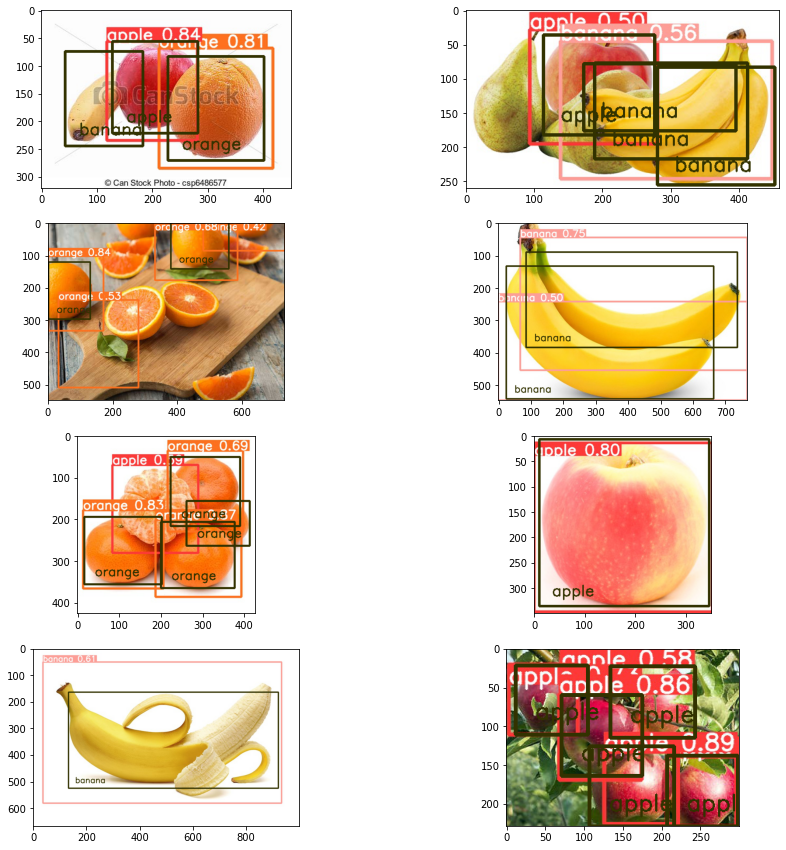

In [ ]:
plotbbox('/content/test/images', '/content/YOLOv5/runs/detect/exp4')

## Plotting GT Box

<ipython-input-192-be1b48d68454>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(4, 2, ind+1)


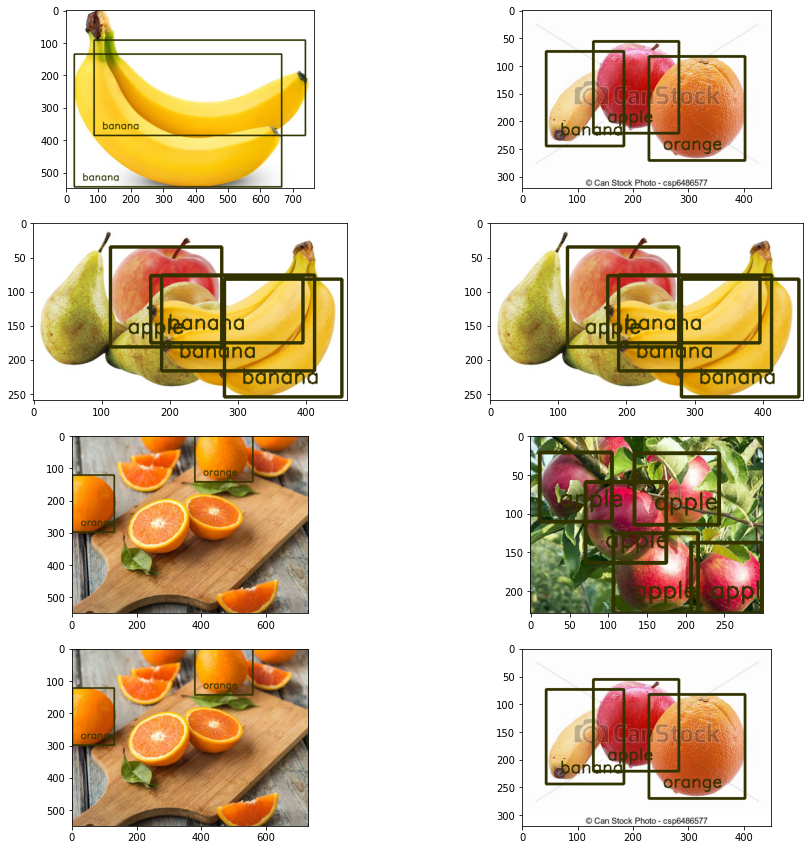

In [ ]:
plotbbox('/content/test/images', '/content/test/images')

# Detectron-2

## Installing Dependencies

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [ ]:
# Roboflow dataset link
!curl -L "https://app.roboflow.com/ds/9LpSoiXaz4?key=NbCyjFemci" > roboflow.zip; 
!unzip roboflow.zip; 
!rm roboflow.zip

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


## Visualizing Training Data

WARNING [12/25 23:44:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/25 23:44:24 d2.data.datasets.coco]: Loaded 582 images in COCO format from /content/train/_annotations.coco.json


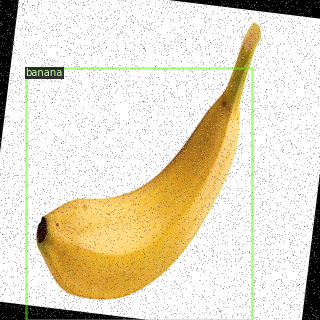

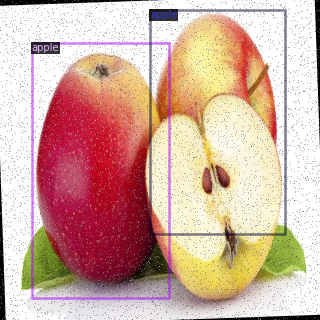

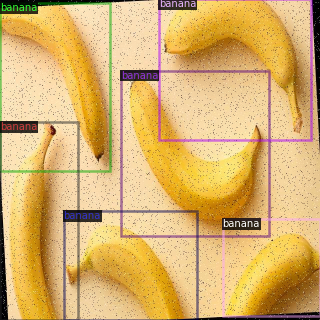

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train Custom Detectron2 Model

In [ ]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 150


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/25 23:44:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:28, 14.7MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/25 23:45:09 d2.engine.train_loop]: Starting training from iteration 0
[12/25 23:45:46 d2.utils.events]:  eta: 0:46:01  iter: 19  total_loss: 1.821  loss_cls: 1.363  loss_box_reg: 0.444  loss_rpn_cls: 0.009  loss_rpn_loc: 0.013  time: 1.8394  data_time: 0.0312  lr: 0.000020  max_mem: 7195M
[12/25 23:46:24 d2.utils.events]:  eta: 0:46:17  iter: 39  total_loss: 1.377  loss_cls: 0.911  loss_box_reg: 0.415  loss_rpn_cls: 0.007  loss_rpn_loc: 0.011  time: 1.8853  data_time: 0.0114  lr: 0.000040  max_mem: 7195M
[12/25 23:47:04 d2.utils.events]:  eta: 0:46:30  iter: 59  total_loss: 0.942  loss_cls: 0.499  loss_box_reg: 0.458  loss_rpn_cls: 0.013  loss_rpn_loc: 0.014  time: 1.9108  data_time: 0.0145  lr: 0.000060  max_mem: 7195M
[12/25 23:47:43 d2.utils.events]:  eta: 0:46:11  iter: 79  total_loss: 1.053  loss_cls: 0.466  loss_box_reg: 0.549  loss_rpn_cls: 0.007  loss_rpn_loc: 0.014  time: 1.9265  data_time: 0.0123  lr: 0.000080  max_mem: 7195M
[12/25 23:48:23 d2.utils.events]:  eta: 0:45:3

## Training Curves

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [12/26 00:35:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/26 00:35:27 d2.data.datasets.coco]: Loaded 9 images in COCO format from /content/test/_annotations.coco.json
[12/26 00:35:27 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   Fruits   | 0            |   apple    | 0            |   banana   | 0            |
|   orange   | 12           |            |              |            |              |
|   total    | 12           |            |              |            |              |
[12/26 00:35:27 d2.data.common]: Serializing 9 elements to byte tensors and concatenating them all ...
[12/26 00:35:27 d2.data.common]: Serialized dataset takes 0.00 MiB
[12/26 00:35:27 d2.evaluation.evaluator]: Start inference on 9 imag

OrderedDict([('bbox',
              {'AP': 48.29432943294329,
               'AP50': 88.36633663366337,
               'AP75': 50.67506750675068,
               'APs': nan,
               'APm': nan,
               'APl': 48.29432943294329,
               'AP-Fruits': nan,
               'AP-apple': nan,
               'AP-banana': nan,
               'AP-orange': 48.29432943294329})])

## Inference with Detectron2 Saved Weights


In [ ]:
%ls ./output/

coco_instances_results.json                         last_checkpoint
events.out.tfevents.1672011880.0c55dcbe0241.1737.0  metrics.json
instances_predictions.pth                           model_final.pth


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

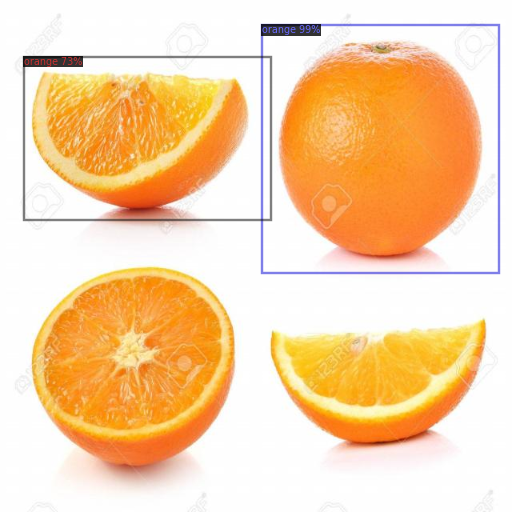

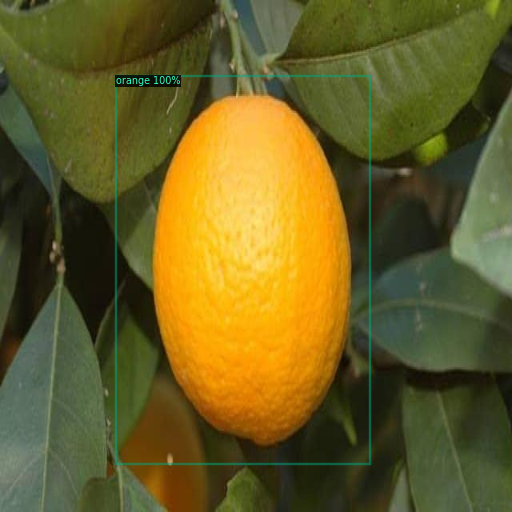

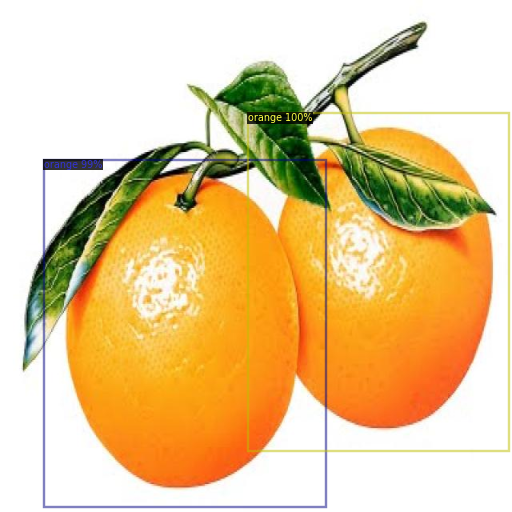

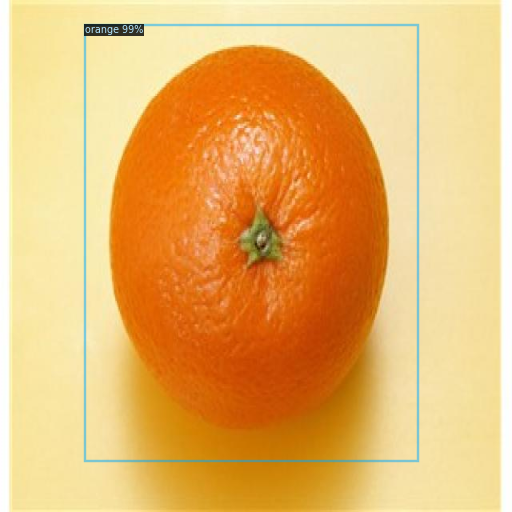

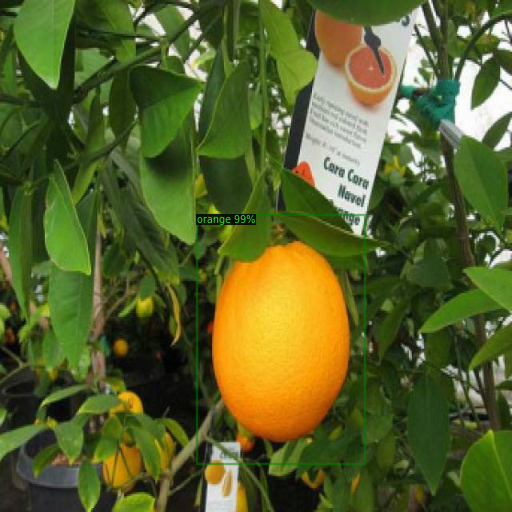

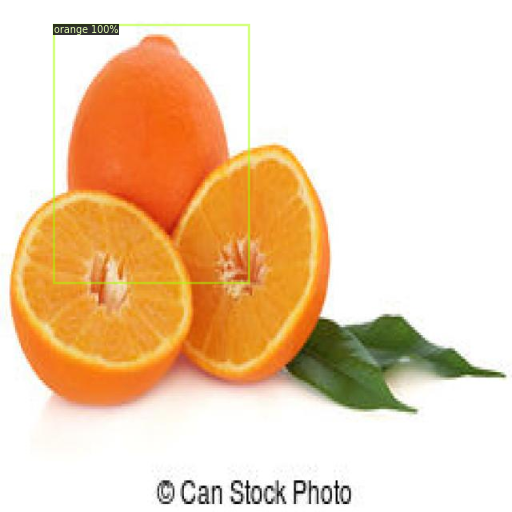

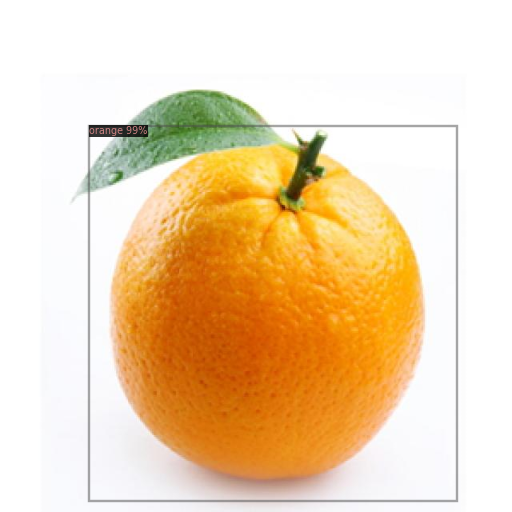

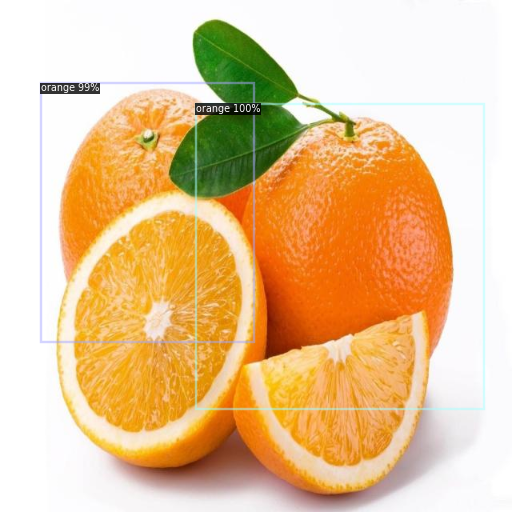

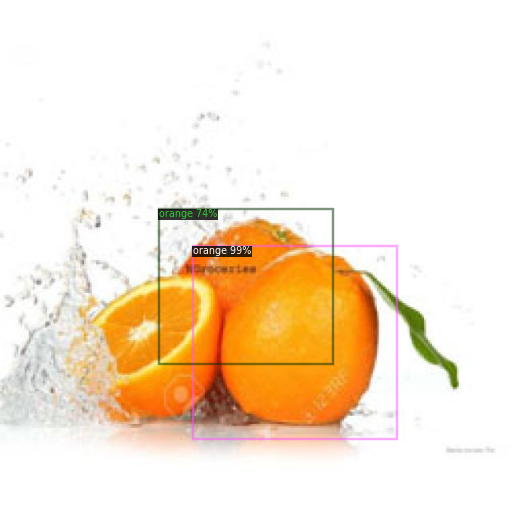

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


## Detectron 2 Inference along with GT Box

In [ ]:
# By using CV2 we can plot GT box on predicted images.
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os
from detectron2.utils.visualizer import ColorMode
import glob

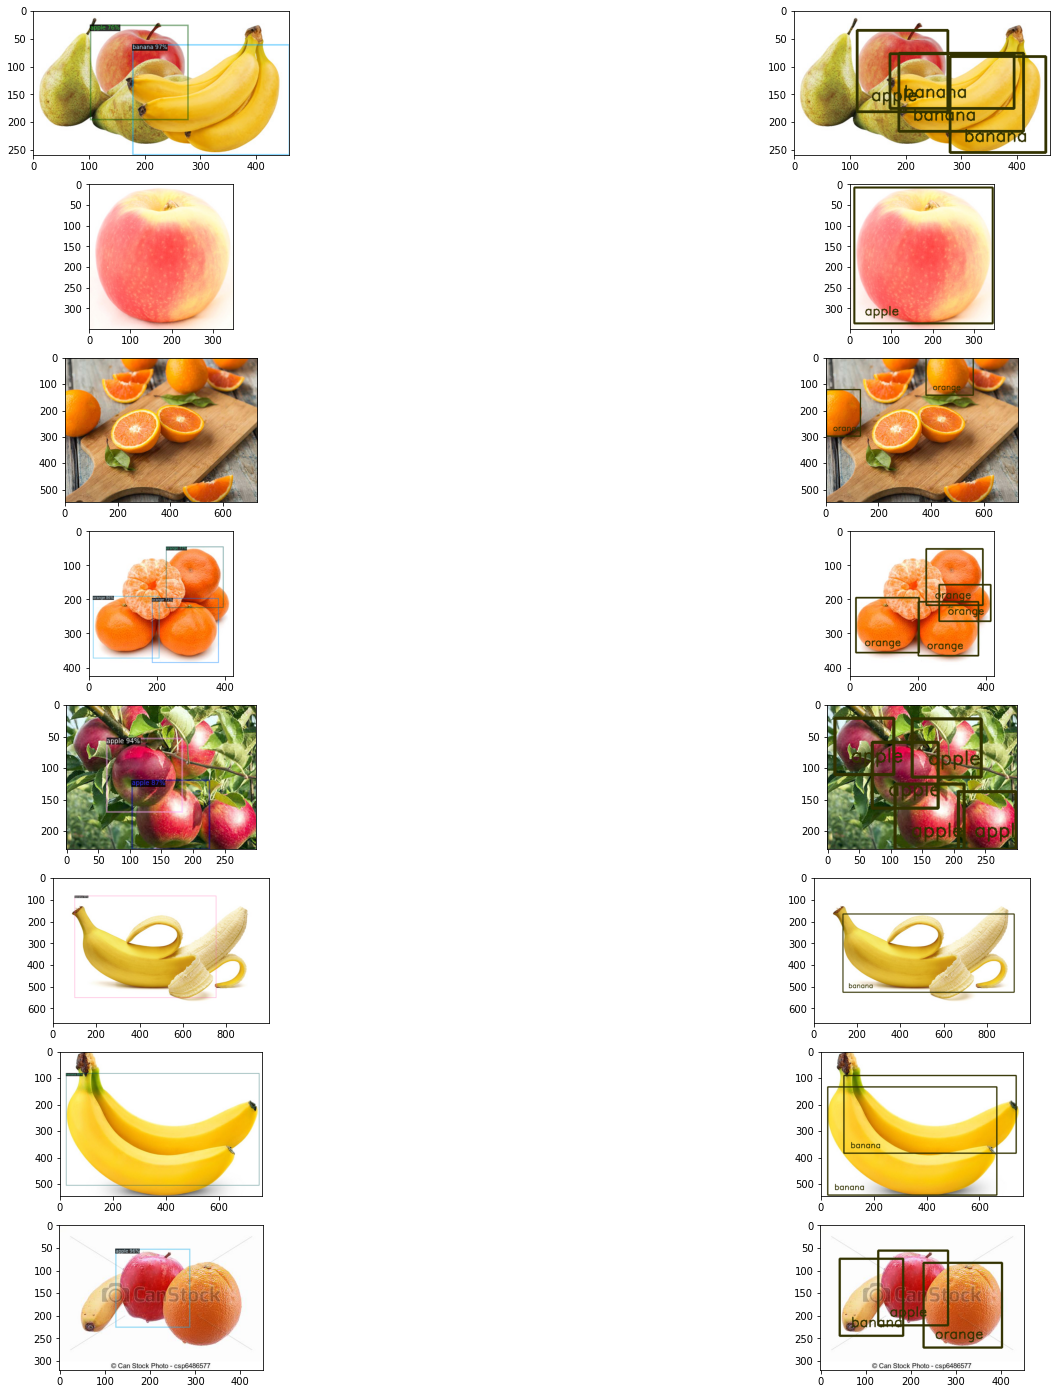

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

plt.figure(figsize=(25, 25))

for ind, imageName in zip(range(8),glob.glob('/content/test/*jpg')):
  xmlPath = imageName.replace('.jpg', '.xml')
  # print(ind, imageName, xmlPath)
  
  # Read XML File
  tree = ET.parse(xmlPath)
  root = tree.getroot()
  
  im = plt.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=1.0
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  img = out.get_image()[:, :, ::-1]
  plt.subplot(8, 2, ind*2+1)
  for data in root.findall('object'):
      bbox = []
      for box in data.find('bndbox'):
        bbox.append(int(box.text))
      xmin, xmax, ymin, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
      # print(xmin, xmax, ymin, ymax, img.shape, im.shape)
      # After getting the bboxes we will not plot a rectangle with OpenCV on image
      cv2.rectangle(im, (int(xmin), int(xmax)), (int(ymin), int(ymax)), (50, 50, 0), 3)
      # Add the label of object above Bounding box drawn in previous step
      cv2.putText(im, data.find('name').text, (xmin+25, ymax-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (50, 50, 0), 2)
  # print(im.shape, im.shape)
  plt.imshow(img)
  plt.subplot(8, 2, ind*2+2)
  plt.imshow(im)
  
# plt.show()
plt.savefig('Detectron2Prediction.jpg')

  # plt.imshow(img)
  # break